# Final Project: Piano Keyboard & Keys Detection

This notebook contains all the code necessary for the project. The use of a notebook format is intended to provide the read with an interactive experience testing and examining individual parts of the pipeline.
While no instructional text are provided here except for code comments, please follow the attached final report, as well as the README.py for a detailed explanation of how to run the system on example data.

In [1]:
%pip install opencv-python matplotlib numpy --quiet
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


## 1. Data Preparation

In [2]:
def extractFrames(video_path, output_path, max_frame_count):
    """ 
    Extracts frames (images) from a video at `video_path` and writes them to `output_path`
    Stops extracting at `max_frame_count` if specified.
    """
    
    video = cv2.VideoCapture(video_path)
    success, img = video.read()

    count = 0
    while success and count < max_frame_count:
        count += 1
        cv2.imwrite(f"{output_path}/frame{count}.jpg", img)
        success, img = video.read()

    print(f"Extracted {count} frames!")

def wipeFolder(folder_path):
    """
    Removes all files in a folder. 
    Intended to be used to delete all frames extracted.
    """
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)

VIDEOS_DIR_PATH = "videos/"
FRAMES_DIR_PATH = "frames/"
TEST_VIDEO = "clair_de_lune.mp4"

# wipeFolder(FRAMES_DIR_PATH) # Use this to wipe "frames" folder
extractFrames(VIDEOS_DIR_PATH + TEST_VIDEO, FRAMES_DIR_PATH, 10)

Extracted 10 frames!


## 2. Frame Preprocessing

Text(0.5, 1.0, 'Thresholded Frame')

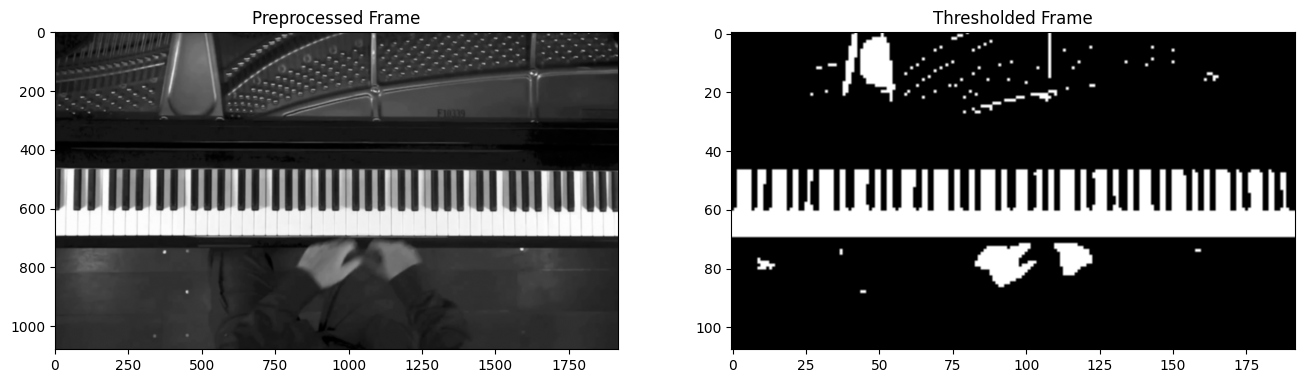

In [3]:
def preProcessFrame(frame_path, kernel_size=(5, 5)):
    """
    Preprocesses a frame at `frame_path`, through the following steps:
        1. Convert to grayscale
        2. Blur with box filter, with `kernel_size`
    Returns the frame.
    """
    # Load frame
    frame = cv2.imread(frame_path)
    if frame is None:
        print("Failed to read frame.")
        return

    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Blur
    frame_blur = cv2.blur(frame_gray, kernel_size)

    return frame_blur

def downsizeFrame(frame, downsize_factor=10):
    """
    Downsizes a `frame` by factor `downsize_factor`.
    Returns the frame
    """
    new_width, new_height = frame.shape[1] // 10, frame.shape[0] // 10
    frame_small = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return frame_small

def binarizeFrame(frame, binary_threshold=100):
    """
    Binarize a `frame`. Pixels above `binary_threshold` is set to white (255), otherwise black (0).
    Returns the frame.
    """
    _, frame_binary = cv2.threshold(frame, binary_threshold, 255, cv2.THRESH_BINARY)
    return frame_binary


# Create preprocessed, downsized, binarized frame
TEST_FRAME = "frame3.jpg"
frame_preprocessed = preProcessFrame(FRAMES_DIR_PATH + TEST_FRAME)
frame_thresholded = binarizeFrame(downsizeFrame(frame_preprocessed), binary_threshold=75)

# Visualize
plt.figure(figsize=(16, 12))
plt.subplot(1, 2, 1)
plt.imshow(frame_preprocessed, cmap="gray")
plt.title("Preprocessed Frame")

plt.subplot(1, 2, 2)
plt.imshow(frame_thresholded, cmap="gray")
plt.title("Thresholded Frame")

## 3. Keyboard Area Detection

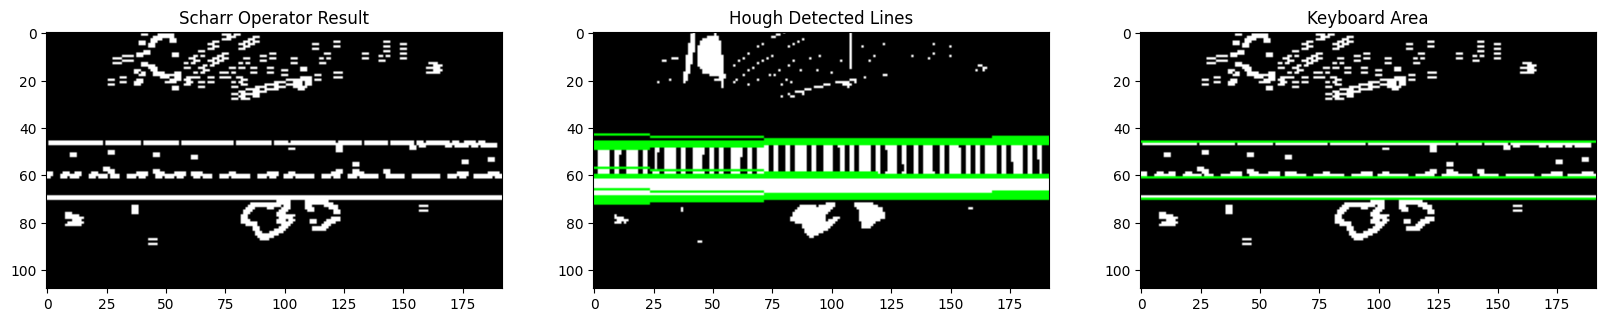

In [4]:
HORIZ_SCHARR_KERNEL = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])
VERT_SCHARR_KERNEL = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])

def applyScharr(img, is_horiz):
    """
    Applies the Scharr operator to a grayscale `img` to find edges in one direction.
    Finds horizontal edges if `is_horiz` is set to True, otherwise vertical edges.
    """
    kernel = HORIZ_SCHARR_KERNEL if is_horiz else VERT_SCHARR_KERNEL
    result = cv2.convertScaleAbs(cv2.filter2D(img, cv2.CV_64F, kernel))

    return result

def findHoughLines(img_edges, 
                   threshold=100, 
                   theta_min=-np.pi/2, theta_max=np.pi/2, theta_step=np.pi/180, 
                   rho_step=1, 
                   use_nms=True, nms_window_size=3):
    """
    Applies a Hough Transform to find lines in an image.
        `img_edges` is intended to be an image of edges found by applying an edge detector (e.g. Scharr)
        `theta_min`, `theta_max`, `theta_step` specify the search space for "theta" parameter in the Hough space
        `rho_step` specifies the step to search the search space for the "rho" parameter
        `use_nms` when set to True will use non-maximum suppression on the Hough space with sliding `nms_window_size`
    Returns an array of lines found in Cartesian coordinates, with the form ((x1, y1), (x2, y2))
    """              
    # Initialize Hough space
    diag_length = np.sqrt(img_edges.shape[0] ** 2 + img_edges.shape[1] ** 2)
    rho_values = np.arange(-diag_length, diag_length, rho_step)
    theta_values = np.arange(theta_min, theta_max, theta_step)
    cos_values = np.cos(theta_values)
    sin_values = np.sin(theta_values)

    hough_space = np.zeros((len(rho_values), len(theta_values)))

    # Search Hough space by iterating over all edge pixels
    for height, width in zip(*np.where(img_edges > 0)):
        for theta_idx in range(len(theta_values)):
            rho = width * cos_values[theta_idx] + height * sin_values[theta_idx]
            closest_valid_rho_idx = np.argmin(abs(rho - rho_values))
            hough_space[closest_valid_rho_idx, theta_idx] += 1
    
    # Apply non-maximum suppression
    if use_nms:
        pad = nms_window_size // 2
        rows, cols = hough_space.shape
        for row in range(pad, rows - pad):
            for col in range(pad, cols - pad):
                window = hough_space[row - pad: row + pad + 1, col - pad: col + pad + 1]

                # Suppress vote if not maximum in window
                if hough_space[row, col] != np.max(window):
                    hough_space[row, col] = 0

    # Get polar coordinates of found lines
    rho_indices, theta_indices = np.where(hough_space > threshold)
    found_rho_values = rho_values[rho_indices]
    found_sin_values = sin_values[theta_indices]
    found_cos_values = cos_values[theta_indices]

    # Convert back to Cartesian coordinates and draw lines
    lines = []
    for rho, sin, cos in zip(found_rho_values, found_sin_values, found_cos_values):
        x0, y0 = rho * cos, rho * sin
        x1 = int(x0 + 1000 * -sin)
        y1 = int(y0 + 1000 * cos)
        x2 = int(x0 - 1000 * -sin)
        y2 = int(y0 - 1000 * cos)
        lines.append((x1, y1, x2, y2))

    return lines

def averageLines(lines, img, num_groups=3, tolerance=10):
    """
    Takes in an array of horizontal `lines` produced by the Hough transform, 
    and group them based on their relative height on `img`.
    
    Might fail to group lines into `num_groups`. Adjusting the `tolerance`
    and prior steps in the pipeline (e.g. binary thresholding) may help produce
    the wanted results.

    Return the averaged lines.
    """
    # Sort lines by descending height
    lines_sorted = sorted(lines, key=lambda line: np.mean([line[1], line[3]]))

    # Group lines by y-coordinate
    line_groups = {}
    for line in lines_sorted:
        x1, y1, x2, y2 = line
        y_avg = np.mean([y1, y2])
        
        # Try to add line to an existing group
        added = False
        for group in line_groups:
            if abs(y_avg - group) < tolerance:
                line_groups[group].append(y_avg)
                added = True
                break
        # Otherwise create a new group
        if not added:
           line_groups[y_avg] = [y_avg]

    if len(line_groups) != num_groups:
        print(f"Warning. Expected {num_groups} line groups. Found {len(line_groups)}.")
    
    # Take average of lines
    result = []
    for line_heights in line_groups.values():
        y_avg = int(np.mean(line_heights))
        result.append((0, y_avg, img.shape[1], y_avg)) 
    
    return result

def rotateFrameMaybe(frame, defining_lines):
    """
    Rotates `frame` 180 degrees if `frame` is found to be upside-down.
    That is, if the keyboard is upside-down (i.e. black keys below the white keys).
    Uses the keyboard area defined by `defining_lines` to extract such information.
    Returns the frame.
    """
    top, middle, bottom = defining_lines
    middle_y = middle[1]
    
    # Extract pixels above and below the middle line
    upper_region = frame[:middle_y, :]
    lower_region = frame[middle_y:, :]

    # Count black key pixels
    upper_black_count = np.sum(upper_region == 0)
    lower_black_count = np.sum(lower_region == 0)
    
    # Rotate if black keys are in lower region
    if lower_black_count > upper_black_count:
        frame = cv2.rotate(frame, cv2.ROTATE_180)

        height = frame.shape[0]
        top = (top[0], height - top[1])
        middle = (middle[0], height - middle[1])
        bottom = (bottom[0], height - bottom[1])

    return frame, [top, middle, bottom]

# Apply Scharr operator to find horizontal edges
frame_scharr = applyScharr(frame_thresholded, is_horiz=True)

# Apply Hough transform to find horizontal lines
hough_lines = findHoughLines(frame_scharr)

# Take average of lines to get 3 defining lines
defining_lines = averageLines(hough_lines, frame_scharr)

# Rotate frame if need be
frame_keyboard_area_final, defining_lines = rotateFrameMaybe(frame_scharr, defining_lines)

# Scharr result
plt.figure(figsize=(20, 12))
plt.subplot(1, 3, 1)
plt.imshow(frame_scharr, cmap="gray")
plt.title("Scharr Operator Result")

# Hough Lines result
img_copy_1 = cv2.cvtColor(frame_thresholded, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in hough_lines:
    cv2.line(img_copy_1, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
plt.subplot(1, 3, 2)
plt.imshow(img_copy_1)
plt.title("Hough Detected Lines")

# Final keyboard area result
img_copy_2 = cv2.cvtColor(frame_keyboard_area_final, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in defining_lines:
    cv2.line(img_copy_2, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
plt.subplot(1, 3, 3)
plt.imshow(img_copy_2)
plt.title("Keyboard Area")
plt.show()

## 4. Keys Detection

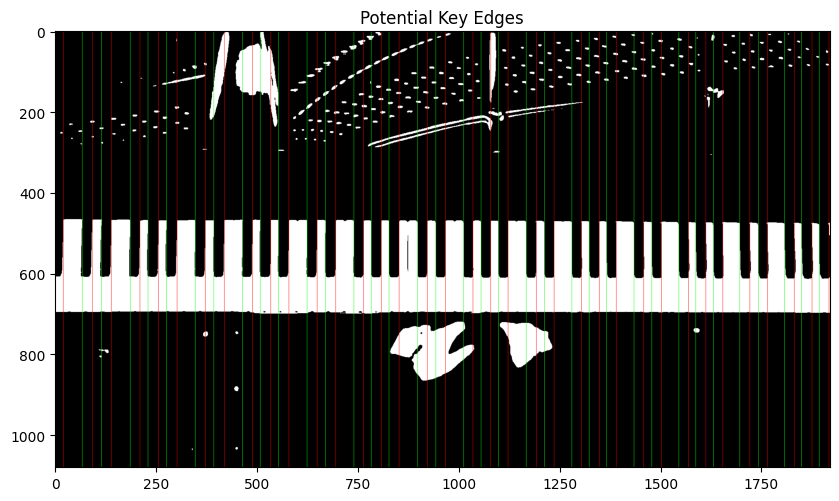

In [5]:
def detectKeyEdges(frame, defining_lines, distance_from_top=20):
    """
    Detects vertical edges of keys on the keyboard in the `frame` based on the
    `defining_lines` that outline the top, middle, and bottom of the keyboard.

    This function takes a horizontal trace of pixels at `distance_from_top` pixels from the top line,
    and identify black and white pixel sequences to identify black-to-white and white-to-black edges.

    Returns the found edges. Each edge is in the form (<x_coordinate>, <edge_color>)
    """
    height, width = frame.shape
    top, middle, bottom = defining_lines
    top_y, middle_y, bottom_y = top[1], middle[1], bottom[1]
    
    # Traverse line parallel
    line = frame[top_y + distance_from_top, :]

    # Detect transitions between black and white keys
    key_edges = []
    prev = None
    for idx in range(1, len(line)):
        if prev is not None and line[idx] != prev:
            color = 1 if prev else 0
            key_edges.append((idx, color))
        prev = line[idx]

    return key_edges

# Use full-sized, grayscale frame because more granularity is required for key edges
binary_threshold = 80
_, frame_binarized = cv2.threshold(frame_preprocessed, binary_threshold, 255, cv2.THRESH_BINARY)

# Scale up defining lines. Get potential edges
upscale_defining_lines = [(x1, y1 * 10, x2, y2 * 10) for x1, y1, x2, y2 in defining_lines]
potential_edges = detectKeyEdges(frame_binarized, upscale_defining_lines)

# Visualize
frame_copy = cv2.cvtColor(frame_binarized, cv2.COLOR_GRAY2BGR)
for edge, is_white_to_black in potential_edges:
    color = (0, 255, 0) if is_white_to_black else (255, 0, 0)
    cv2.line(frame_copy, (edge, 0), (edge, frame_copy.shape[1]), color, thickness=1)
plt.figure(figsize=(10, 8))
plt.imshow(frame_copy)
plt.title("Potential Key Edges")
plt.show()

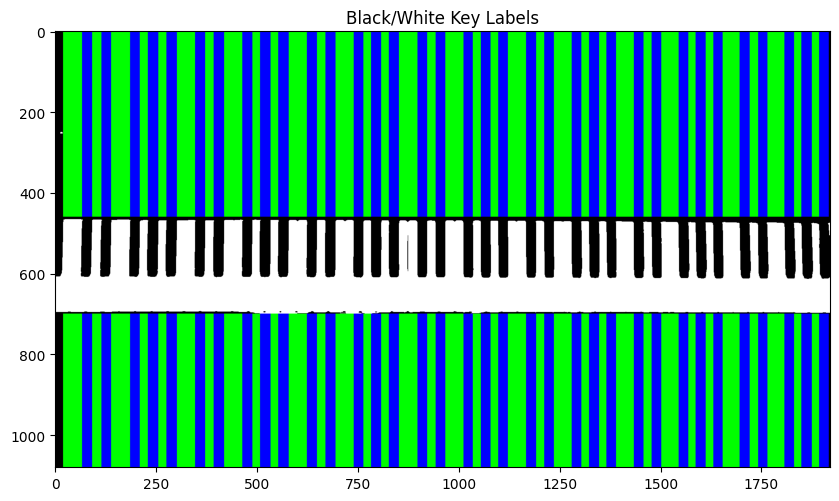

In [6]:
def labelKeys(edges, tolerance_ratio=0.5):
    """
    Takes in an array of vertical `edges` between keys,
    and label each key as black (B), white (W), or consecutive whites (WW).

    Each input edge is in the form (<x_coord>, <color>), intended to be outputs from `detectKeyEdges()`.
    The ratio `tolerance_ratio` is how much deviation from a true key width can still be accepted as a key.
    
    Each output key is in the form (<label>, <left_edge>, <right_edge>)
        `label` is one of "B", "W", or "WW".
        `left_edge` and `right_edge` are left and right edges of the key in the original input form.
    """
    # Find true width between each pair of edges
    widths = [edges[i][0] - edges[i - 1][0] for i in range(1, len(edges))]
    rounded_widths = [round(w, -1) for w in widths] # Round to nearest 10 pixel
    true_width = Counter(rounded_widths).most_common(1)[0][0]
    
    # Label keys as black/white
    keys = []
    tolerance = tolerance_ratio * true_width
    for i in range(1, len(edges)):
        width = edges[i][0] - edges[i - 1][0]
        color = edges[i][1]

        if abs(width - true_width) < tolerance:
            label = "W" if color else "B"
            keys.append((label, edges[i - 1], edges[i]))
        elif abs(width - 2 * true_width) < tolerance:
            keys.append(("WW", edges[i - 1], edges[i]))

    return keys

# Label keys
keys = labelKeys(potential_edges)
top, _, bottom = upscale_defining_lines

# Visualize result
frame_copy = cv2.cvtColor(frame_binarized, cv2.COLOR_GRAY2BGR)
for key in keys:
    label, left_edge, right_edge = key
    fill_color = (0, 255, 0) if "W" in label else (0, 0, 255)

    frame_copy[0:top[1], left_edge[0]:right_edge[0]] = fill_color
    frame_copy[bottom[1]:, left_edge[0]:right_edge[0]] = fill_color

plt.figure(figsize=(10, 8))
plt.imshow(frame_copy)
plt.title("Black/White Key Labels")
plt.show()


In [7]:
def interpolateWhiteKeys(keys):
    """
    This function takes in an array of `keys` and specifically deals
    with interpolating any consecutive white keys (labeled "WW") into individual white keys.

    Each input key is in the form (<label>, <left_edge>, <right_edge>). Should be the output of `labelKeys()`

    Returns a pair of arrays (real_keys, real_edges), where:
        `real_keys` is the array of interpolated keys as described above
        `real_edges` is an array of new edges now that consecutive white keys have been broken up
    Each output key is in its original form, now with only labels "W" or "B"
    Each output edge is in the form (<x_coord>, <color>)
    """
    real_keys = []
    for key in keys:
        label, left_edge, right_edge = key

        if label == "B" or label == "W":
            real_keys.append(key)
        else:
            middle = int(np.mean([left_edge[0], right_edge[0]]))
            middle_edge = (middle, 1) # 1 still means edge leaving a white key

            real_keys.append(("W", left_edge, middle_edge))
            real_keys.append(("W", middle_edge, right_edge))
    
    real_edges = []
    for _, left_edge, right_edge in real_keys:
        real_edges.append(left_edge)
    real_edges.append(right_edge)

    return real_keys, real_edges

# Now all keys are either W or B
real_keys, real_edges = interpolateWhiteKeys(keys)

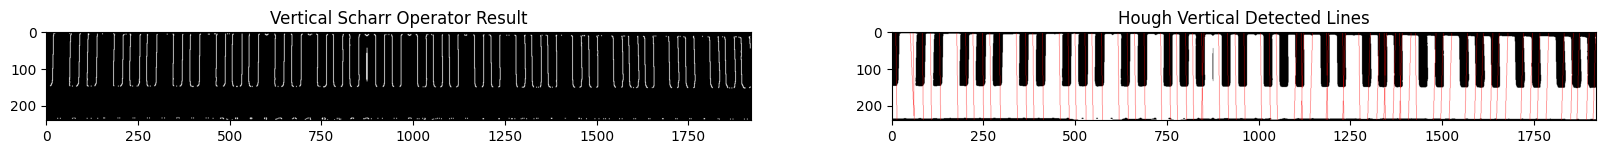

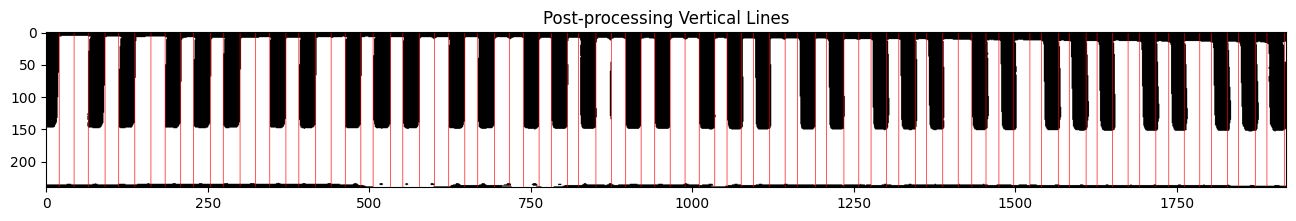

In [8]:
# Associate found edges with lines detected by Hough transform
def pairEdgeLines(edges, vert_lines):
    """
    Takes in an array of `edges` and an array of vertical lines `vert_lines`,
    and associate each edge with a vertical line.

    This function operates by iterating over each edge and the vertical lines in sorted
    order, assigning each line to the current edge if they are close enough in x-coordinate.

    In the end, one edge should only be associated with a single vertical line. 
        If multiple lines are found for one edge, they are averaged by their x-coordinate. 
        If an edge has no line associated with it, it is ideally the case that this is an interpolated 
            edge between two white keys, and an interpolated line is produced.

    Each edge is in the form (<x_coord>, <color>).
    Each vertical line is in the form (x1, x2, y1, y2)

    Return an array of pairs, where each pair is an edge and a vertical line, (<edge>, <vertical_line>).
    """
    _, y_top, _, y_bottom = vert_lines[0]

    # Sort vertical lines from left to right
    sorted_vert_lines = sorted(vert_lines, key=lambda line: np.mean([line[0], line[2]]))
    idx_line = 0

    tolerance = 10 # pixels

    # Match Hough vertical lines to edges
    edge_to_lines_map = {}
    for edge in edges:
        x_edge, is_white_to_black = edge
        edge_to_lines_map[x_edge] = []

        # Find all lines close to edge
        while idx_line < len(sorted_vert_lines):
            x1, y1, x2, y2 = sorted_vert_lines[idx_line]
            mean_x = np.mean([x1, x2])

            # If line is within tolerance, consider it attached to edge
            if abs(x_edge - mean_x) < tolerance:
                edge_to_lines_map[x_edge].append((x1, y1, x2, y2))
                idx_line += 1
            # If too far forward, we must be at the next edge. Move on
            elif mean_x > x_edge:
                break
            # Handles line being too far behind
            else:
                idx_line += 1
        
        # Interpolated edge. Add a line 
        if not edge_to_lines_map[x_edge]:
            edge_to_lines_map[x_edge].append((x_edge, y_top, x_edge, y_bottom))

    # Take average just in case. Empirically 1-2 lines are matched to each edge
    for edge, lines in edge_to_lines_map.items():
        avg_x = 0
        for x1, _, x2, _ in lines:
            avg_x += np.mean([x1, x2])
        avg_x = int(avg_x / len(lines))

        edge_to_lines_map[edge] = (avg_x, y_top, avg_x, y_bottom)

    return [(edge, line) for edge, line in edge_to_lines_map.items()]

# Find vertical lines
sectioned_frame_binarized = frame_binarized[top[1]:bottom[1], :]

# Apply Scharr to find vertical edges
frame_scharr_vert = applyScharr(sectioned_frame_binarized, is_horiz=False)

# Apply Hough transform to find vertical lines
hough_lines_vert = findHoughLines(frame_scharr_vert, theta_min=-np.pi/24, theta_max=np.pi/24, theta_step=np.pi/90)
hough_lines_vert = [(x1, 0, x2, frame_scharr_vert.shape[1]) for x1, _, x2, _ in hough_lines_vert]

# Match edges to lines
edge_line_pairs = pairEdgeLines(real_edges, hough_lines_vert)

# Scharr result
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(frame_scharr_vert, cmap="gray")
plt.title("Vertical Scharr Operator Result")

# Hough Lines result
frame_copy_1 = cv2.cvtColor(sectioned_frame_binarized, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in hough_lines_vert:
    cv2.line(frame_copy_1, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
plt.subplot(1, 2, 2)
plt.imshow(frame_copy_1)
plt.title("Hough Vertical Detected Lines")

# Post-processing Vertical Lines
frame_copy_2 = cv2.cvtColor(sectioned_frame_binarized, cv2.COLOR_GRAY2BGR)
for edge, line in edge_line_pairs:
    x1, y1, x2, y2 = line
    cv2.line(frame_copy_2, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)
plt.figure(figsize=(16, 12))
plt.imshow(frame_copy_2)
plt.title("Post-processing Vertical Lines")
plt.show()

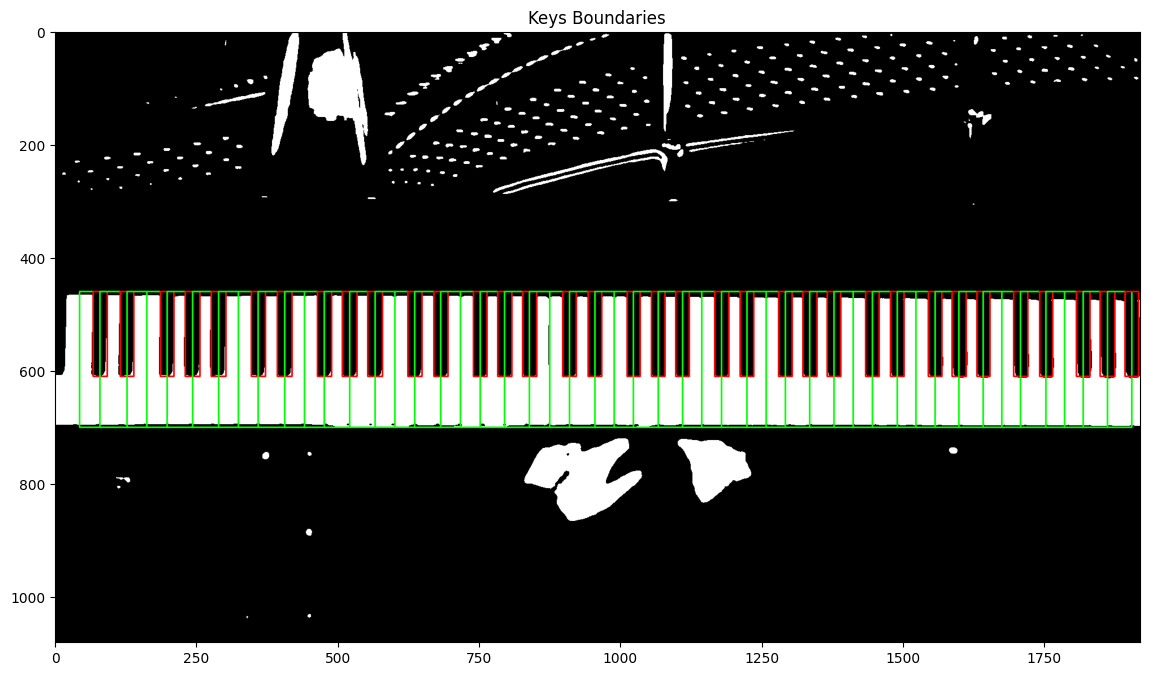

In [9]:
def findKeyBoundaries(keys, edge_line_pairs, defining_lines):
    """
    Finds the bounding boxes for `keys` based on the `defining_lines` of the keyboard,
    and the vertical lines that define each key found in `edge_line_pairs`.

    Each key in the `keys` array is in the form (<label>, <left_edge>, <right_edge>).
    Each pair in the `edge_line_pairs` array (<edge>, <vertical_line>).
        Thus, these two variables are used together to interpret the vertical lines that bound a key.
    The `defining_lines` contain three lines (top, middle, bottom) that define the keyboard area.

    This function relies on the sub-routine `calculateKeyCorners` to calculate the bounding box of each key,
    which handles interpreting the bounding box for different cases of key positions.

    Returns a pair (key, bounds) where key is the original key, and bounds is a pair 
    of top-left and bottom-right coordinates of the key's bounding box.
    """
    top, middle, bottom = defining_lines
    
    boundaries = []
    for i, key in enumerate(keys):
        next_key = keys[i + 1] if i + 1 < len(keys) else None
        prev_key = keys[i - 1] if i - 1 >= 0 else None
        key_boundaries = calculateKeyCorners(key, prev_key, next_key, top[1], middle[1], bottom[1])
        boundaries.append(key_boundaries)

    return [(key, bounds) for key, bounds in list(zip(keys, boundaries)) if bounds is not None]

def calculateKeyCorners(key, prev_key, next_key, top, middle, bottom):
    """
    Calculates the corners of the bounding box for a `key`.

    Takes in the `prev_key` and `next_key` to interpret various information about the current key's bounding box.
    Also takes in `top`, `middle`, `bottom` which are the y-coordinates of the defining lines of the keyboard.

    Each of the input keys has the form (<label>, <left_edge>, <right_edge>)
    There are 4 cases possible for the bounding box of a key, based on whether the key is preceded and followed
    by a black or white key. Based on this information, the routine uses the left and right edges of the current,
    previous, and next keys to differently define the current key's bounding box.

    Returns a pair of coordinates (<top_left_coord>, <bottom_right_coord>) of the bounding box,
    where each coordinate is in the form (x, y).
    """
    label, left_edge, right_edge = key
    left, _ = left_edge
    right, _ = right_edge

    # Case 1: Black key, always followed and preceded by white key
    if label == "B":
        top_left = (left, top)
        bottom_right = (right, middle)
        return (top_left, bottom_right)

    # Extract previous and next key if possible
    prev_label, prev_left_edge, _ = prev_key if prev_key else (None, None, None)
    next_label, _, next_right_edge = next_key if next_key else (None, None, None)
    prev_left, _ = prev_left_edge if prev_left_edge else (None, None)
    next_right, _ = next_right_edge if next_right_edge else (None, None)
    
    top_left, bottom_right = None, None

    # Case 2: White key followed by black key, preceded by white key (e.g. C)
    if label == "W" and next_label == "B" and prev_label == "W":
        top_left = (left, top)
        bottom_right = (int(np.mean([right, next_right])), bottom)
    # Case 3: White key followed by white key, preceded by black key (e.g. B)
    elif label == "W" and next_label == "W" and prev_label == "B":
        top_left = (int(np.mean([prev_left, left])), top)
        bottom_right = (right, bottom)
    # Case 4: White key followed by black key, preceded by black key (e.g. D)
    elif label == "W" and next_label == "B" and prev_label == "B":
        top_left = (int(np.mean([prev_left, left])), top)
        bottom_right = (int(np.mean([right, next_right])), bottom)
    
    return (top_left, bottom_right) if (top_left is not None and bottom_right is not None) else None

# Get the keys with boundaries attached
keys_with_boundaries = findKeyBoundaries(real_keys, edge_line_pairs, upscale_defining_lines)

# Visualize
frame_copy = cv2.cvtColor(frame_binarized, cv2.COLOR_GRAY2BGR)
for key, boundaries in keys_with_boundaries:
    color = (255, 0, 0) if key[0] == "B" else (0, 255, 0)
    top_left, bottom_right = boundaries
    cv2.rectangle(frame_copy, top_left, bottom_right, color, thickness=2)
plt.figure(figsize=(14, 10))
plt.imshow(frame_copy)
plt.title("Keys Boundaries")
plt.show()

# 5. Key Identification

In [10]:
VALID_KEY_SEQUENCE = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
VALID_KEY_SEQUENCE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "Bb", "B"]

def nameKeys(keys):
    """
    Takes in an array of `keys`, and uses discrete cross-correlation to
    assign a name (note) to each key.

    The routine uses a known valid sequence of key extended to be longer than the input sequence.
    Then, it runs cross-correlation on the two sequence, identifying the index at which the input
    sequence best matches the known sequence. From there, the key names are assigned for the input
    sequence if it is found to be valid.

    Each key is a key associated with their boundaries, resulting from the routine `findKeyBoundaries()`.
    They are in the form ((<label>, <left_edge>, <right_edge>), <boundaries>).
    While this function does not explicitly need boundaries information, it also serves to organize the tuple
    containing all information about a key (name, label, edges, boundaries).

    Returns an array of tuples with the form (<name>, <key>, <boundaries>) for each named key.
    """
    key_labels = [1 if label == "W" else 0 for (label, _, _), _ in keys]

    # Extend valid sequence to be longer than test sequence
    valid_sequence = VALID_KEY_SEQUENCE * (len(key_labels) // len(VALID_KEY_SEQUENCE) + 2) # 2 for rounding safety
    valid_sequence = valid_sequence[:len(key_labels) + 12]

    # Run cross-correlation
    correlation = np.correlate(key_labels, valid_sequence, mode="valid")

    # Find best alignment
    max_corr_idx = np.argmax(correlation)
    max_corr = correlation[max_corr_idx]

    # Validate sequence
    is_valid = (max_corr == sum(key_labels))
    if not is_valid:
        print("Failed to identify valid key sequence.")
        return None

    # Name keys
    start_key_idx = max_corr_idx % len(VALID_KEY_SEQUENCE)
    start_key_name = VALID_KEY_SEQUENCE_NAMES[start_key_idx]

    key_names = []
    cur_idx = VALID_KEY_SEQUENCE_NAMES.index(start_key_name)
    for key in key_labels:
        key_names.append(VALID_KEY_SEQUENCE_NAMES[cur_idx])
        cur_idx = (cur_idx + 1) % len(VALID_KEY_SEQUENCE)

    return [(name, key, boundaries) for (name, (key, boundaries)) in zip(key_names, keys)]

# Get final named, bounded keys
keys_with_names_and_boundaries = nameKeys(keys_with_boundaries)

## 6. Finalize Results

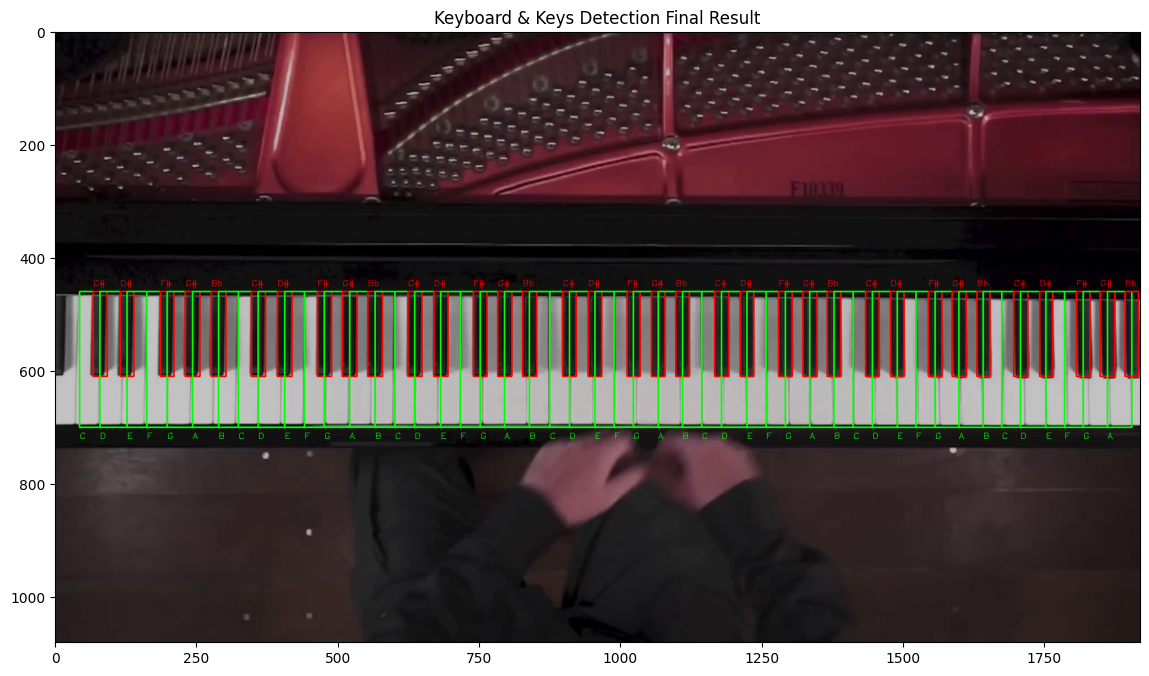

In [11]:
# Visualize final result
frame_showcase = cv2.cvtColor(cv2.imread(FRAMES_DIR_PATH + TEST_FRAME), cv2.COLOR_BGR2RGB)
for name, key, boundaries in keys_with_names_and_boundaries:
    # Draw bounding rect
    color = (255, 0, 0) if key[0] == "B" else (0, 255, 0)
    top_left, bottom_right = boundaries
    cv2.rectangle(frame_showcase, top_left, bottom_right, color, thickness=2)

    # Add key name
    text_position = (top_left[0], bottom_right[1] + 20) if key[0] == "W" else (top_left[0], top_left[1] - 10)
    cv2.putText(frame_showcase, name, text_position, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=1)

plt.figure(figsize=(14, 10))
plt.imshow(frame_showcase)
plt.title("Keyboard & Keys Detection Final Result")
plt.show()

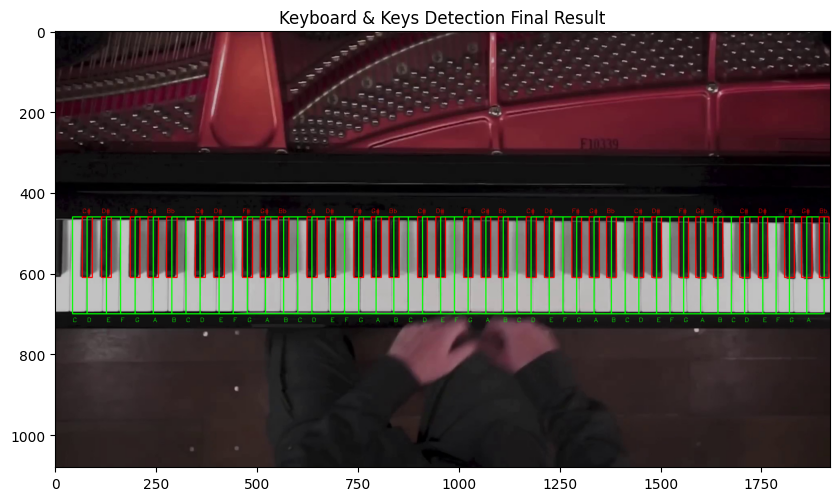

Finished 1 iteration!


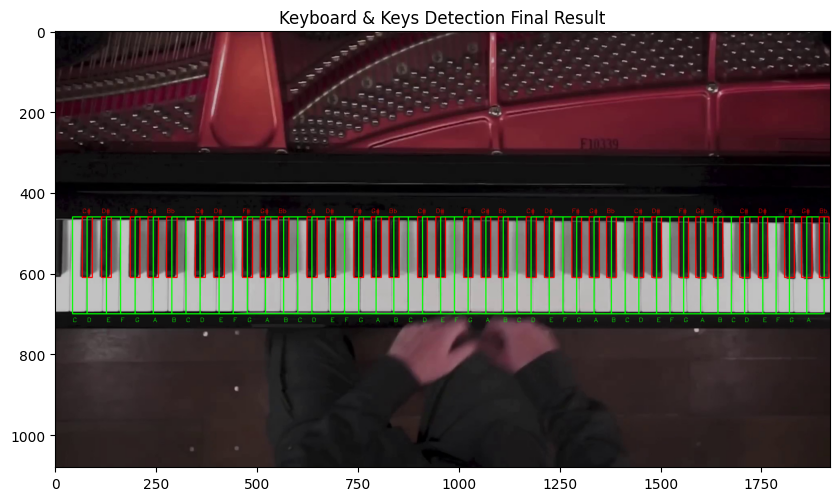

Finished 2 iteration!


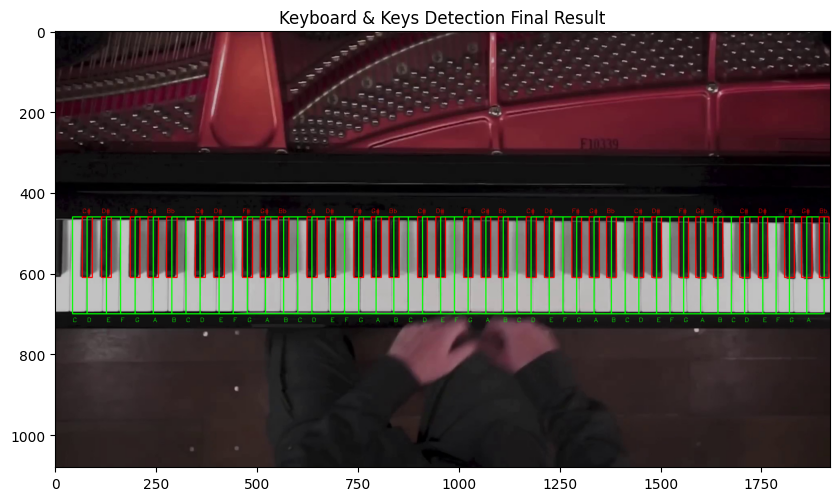

Finished 3 iteration!


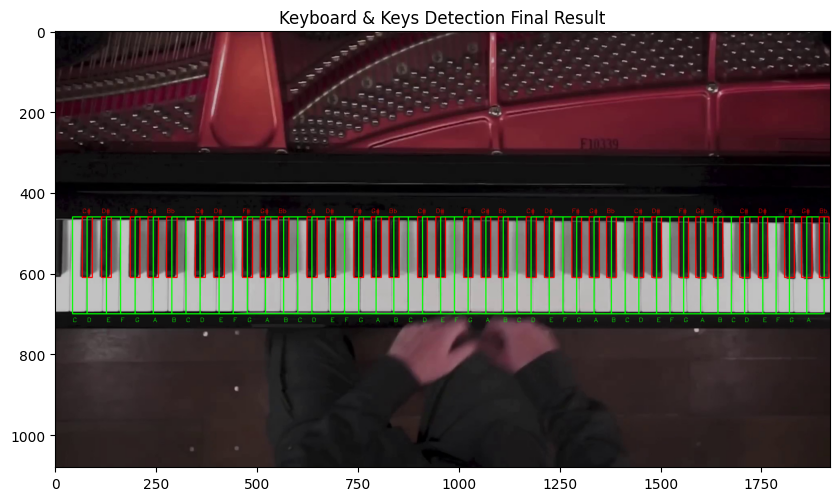

Finished 4 iteration!


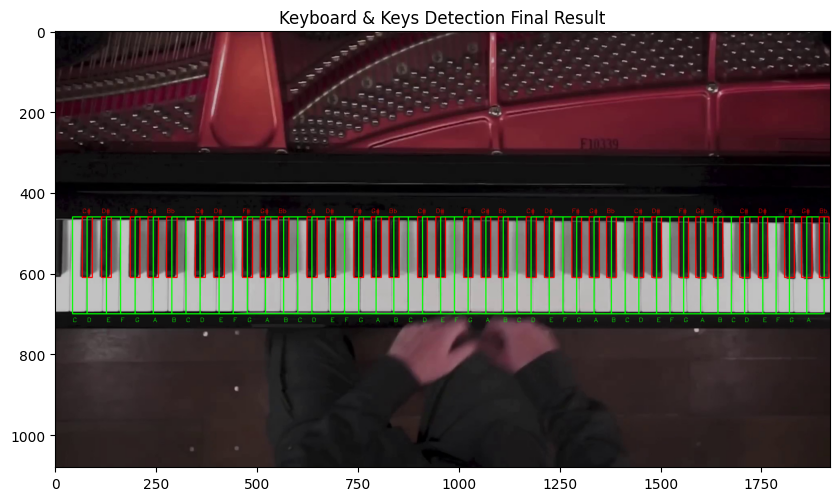

Finished 5 iteration!


In [12]:
# Test routine on multiple frames
downsize_scale = 10
binary_threshold_for_keyboard_area = 75
binary_threshold_for_keys = 80

num_frames = 5
for i in range(1, num_frames + 1):

    # Create preprocessed, downsized, binarized frame
    frame_preprocessed = preProcessFrame(FRAMES_DIR_PATH + TEST_FRAME)
    frame_thresholded = binarizeFrame(downsizeFrame(frame_preprocessed, downsize_factor=downsize_scale), binary_threshold=binary_threshold_for_keyboard_area)

    # Apply Scharr operator to find horizontal edges
    frame_scharr = applyScharr(frame_thresholded, is_horiz=True)

    # Apply Hough transform to find horizontal lines
    hough_lines = findHoughLines(frame_scharr)

    # Take average of lines to get 3 defining lines
    defining_lines = averageLines(hough_lines, frame_scharr)

    # Rotate frame if need be
    frame_keyboard_area_final, defining_lines = rotateFrameMaybe(frame_scharr, defining_lines)

    # Use full-sized, grayscale frame because more granularity is required for key edges
    _, frame_binarized = cv2.threshold(frame_preprocessed, binary_threshold_for_keys, 255, cv2.THRESH_BINARY)

    # Scale up defining lines. Get potential edges
    upscale_defining_lines = [(x1, y1 * downsize_scale, x2, y2 * downsize_scale) for x1, y1, x2, y2 in defining_lines]
    potential_edges = detectKeyEdges(frame_binarized, upscale_defining_lines)

    # Label keys
    keys = labelKeys(potential_edges)

    # Iterpolate keys
    real_keys, real_edges = interpolateWhiteKeys(keys)

    # Apply Scharr to find vertical edges
    sectioned_frame_binarized = frame_binarized[top[1]:bottom[1], :]
    frame_scharr_vert = applyScharr(sectioned_frame_binarized, is_horiz=False)

    # Apply Hough transform to find vertical lines
    hough_lines_vert = findHoughLines(frame_scharr_vert, theta_min=-np.pi/24, theta_max=np.pi/24, theta_step=np.pi/90)
    hough_lines_vert = [(x1, 0, x2, frame_scharr_vert.shape[1]) for x1, _, x2, _ in hough_lines_vert]

    # Match edges to lines
    edge_line_pairs = pairEdgeLines(real_edges, hough_lines_vert)

    # Get the keys with boundaries attached
    keys_with_boundaries = findKeyBoundaries(real_keys, edge_line_pairs, upscale_defining_lines)

    # Get final named, bounded keys
    keys_with_names_and_boundaries = nameKeys(keys_with_boundaries)

    # Visualize final result
    frame_showcase = cv2.cvtColor(cv2.imread(FRAMES_DIR_PATH + TEST_FRAME), cv2.COLOR_BGR2RGB)
    for name, key, boundaries in keys_with_names_and_boundaries:
        # Draw bounding rect
        color = (255, 0, 0) if key[0] == "B" else (0, 255, 0)
        top_left, bottom_right = boundaries
        cv2.rectangle(frame_showcase, top_left, bottom_right, color, thickness=2)

        # Add key name
        text_position = (top_left[0], bottom_right[1] + 20) if key[0] == "W" else (top_left[0], top_left[1] - 10)
        cv2.putText(frame_showcase, name, text_position, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=color, thickness=1)

    plt.figure(figsize=(10, 8))
    plt.imshow(frame_showcase)
    plt.title("Keyboard & Keys Detection Final Result")
    plt.show()

    print(f"Finished {i} iteration!")

## Acknowledgements
This project takes inspiration from and relies heavily on the explanations from the paper titled "Key Detection for a Virtual Piano Teacher" by Adam Goodwin and Richard Green.
DOI: https://doi.org/10.1109/IVCNZ.2013.6727030

The video used to test the system is titled "Debussy 'Clair de Lune' - Paul Barton, FEURICH 218 grand piano" by Paul Barton on Youtube. [https://www.youtube.com/watch?v=4fvo_iOuSck]

The Hough Line Transform implementation was written after reading and understanding the following articles:
- "Implementing the Hough Transform from Scratch" by Alberto Formaggio. [https://medium.com/@alb.formaggio/implementing-the-hough-transform-from-scratch-09a56ba7316b]
- "Hough Line Transform" tutorial by OpenCV. [https://docs.opencv.org/4.x/d6/d10/tutorial_py_houghlines.html]
- "Hough Line Transform" usage examples by OpenCV. [https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html]

Numerous OpenCV, Matplotlib, and Numpy functions were used in this project. Their usage were guided by official documentation pages and online searching.